In [1]:
!pip install transformers torch torchvision pandas nltk
!nvidia-smi

Sat May  4 11:21:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd
from transformers import BertTokenizer, BertConfig, BertModel
from torchvision import transforms
import torch.nn as nn
import io
import pickle  # Added for data storage
import re
import nltk
import json
import functools
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from PIL import Image
from torch.utils.data import Dataset, DataLoader, IterableDataset
import torch.nn as nn
import torchvision
import torch
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from pathlib import Path
import subprocess
import matplotlib.pyplot as plt

bert_model_name = "setu4993/LaBSE"
nltk.download('punkt')
nltk.download('wordnet', '/usr/share/nltk_data')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


**Text Preprocessing**

In [4]:
# Preprocess text descriptions
def preprocess_text(text):
    text = text.lower()  # Lowercase
    pattern = r'\((?!(mw-parser-output|English|Bengali pronunciation|Kannada pronunciation|IPA|Gujarati|Hindi))[^)]+\)'
    text = re.sub(pattern, '', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    words = word_tokenize(text)
    # Lemmatize and remove stop words
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    return text

# Define a function to apply preprocess_text to each row in parallel
def parallel_preprocess_text(text):
    return preprocess_text(text)

In [5]:
#Load the data
data_path = "/kaggle/input/city-data/all_city_data.json"
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)
    
city_df = pd.DataFrame(data)
# Number of parallel processes
num_processes = 4
# Create a Pool of processes
pool = Pool(num_processes)

# data["text"] = data["paragraphs"].apply(preprocess_text)
# Apply preprocess_text function to each row in parallel
city_df["text"] = pool.map(parallel_preprocess_text, city_df["paragraphs"])

# Close the Pool
pool.close()
pool.join()

In [6]:
city_df.to_csv('all_city_data_nostopwords.csv', index=False)

In [7]:
data_path = 'all_city_data_nostopwords.csv'
data = pd.read_csv(data_path)

**Data Preparation**

In [8]:
# Define image transformations (adjust as needed)
transform = transforms.Compose([
    transforms.Resize(256),  # Resize image
    transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
class CityDataset(Dataset):
    def __init__(self, data, image_dir):
        self.data = data
        self.image_dir = Path(image_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        city_name = self.data.loc[idx, 'city']
        image_folder = self.image_dir / city_name  # Path to the city folder

        # Get all image file paths in the folder
        image_paths = list(image_folder.glob("*.jpg")) + list(image_folder.glob("*.jpeg")) +  list(image_folder.glob("*.png")) + list(image_folder.glob("*.webp")) + list(image_folder.glob("*.JPG")) + list(image_folder.glob("*.JPEG")) +  list(image_folder.glob("*.PNG")) + list(image_folder.glob("*.WEBP")) + list(image_folder.glob("*.avif")) + list(image_folder.glob("*.AVIF"))
        #print('All images: ', image_paths)

        # Check if any image found
        if not image_paths:
          raise FileNotFoundError(f"No image found in folder: {image_folder}")

        images = []
        for path in image_paths[:5]:
            image = Image.open(str(path)).convert('RGB')  # Ensure RGB format

            # Apply transformations using your existing transform function
            image = transform(image)
            images.append(image)

        # Load and encode text
        tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        text = self.data.loc[idx, 'text']
        encoded_text = tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")

        # Get city name
        city_name = self.data.loc[idx, 'city']
        
        return torch.stack(images), encoded_text, city_name

In [9]:
# Shuffle DataFrame and reset indices
data_shuffled = data.sample(frac=1, random_state=42)  # Shuffle with random seed
data_shuffled = data_shuffled.reset_index(drop=True)  # Reset indices

# Split into train and test sets
test_size = 0.2
train_data, test_data = train_test_split(data_shuffled, test_size=test_size)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

# Create separate CityDataset instances for training and test data
data_path = '/kaggle/input/city-images/City Images - Copy (copy)/City Images - Copy (copy)'
train_dataset = CityDataset(train_data, data_path)
test_dataset = CityDataset(test_data, data_path)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)  # Don't shuffle test data

print('Data preparation step completed!')


Training data shape: (343, 3)
Testing data shape: (86, 3)
Data preparation step completed!


**Model Definition**

In [10]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [11]:
class ImageEncoder(nn.Module):
  def __init__(self, pretrained_model_name="resnet50"):
    super(ImageEncoder, self).__init__()
    # Load a pre-trained image classification model (e.g., ResNet50)
    self.resnet = getattr(torchvision.models, pretrained_model_name)(pretrained=True)
    self.out_features = self.resnet.fc.in_features  # Assuming fc is the last layer
    # Remove the last classification layer
    self.resnet.fc = nn.Identity()

  def forward(self, x):
    # Pass image through the pre-trained model (excluding classification layer)
    x = x.view(-1, x.size(2), x.size(3), x.size(4))
    x = self.resnet(x)
    return x

class TextEncoder(nn.Module):
    def __init__(self, bert_model_name=bert_model_name):
        super(TextEncoder, self).__init__()
        # Load a pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert = self.bert.eval()

        config = BertConfig.from_pretrained(bert_model_name)

        # Get the number of units in the last layer
        self.out_features = config.hidden_size

    def forward(self, x):
        # Encode text using BERT tokenizer
        input_ids = x['input_ids']
        attention_mask = x['attention_mask']
        with torch.no_grad():
            output = self.bert(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))
        pooled_output = output.pooler_output
        return pooled_output

class ProjectionNetwork(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(ProjectionNetwork, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.relu = nn.ReLU(inplace=True)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

class ContrastiveModel(nn.Module):
  def __init__(self, image_encoder, text_encoder, projection_dim, temperature=0.7):
    super(ContrastiveModel, self).__init__()
    self.image_encoder = image_encoder
    self.text_encoder = text_encoder
    self.image_projection = ProjectionNetwork(image_encoder.out_features, 512, projection_dim)
    self.text_projection = ProjectionNetwork(text_encoder.out_features, 512, projection_dim)
    self.temperature = temperature

  def forward(self, images, text):
    # Encode image and text
    #image_features = self.image_encoder(image)
    image_features = self.image_encoder(images)
    text_features = self.text_encoder(text)

    # Project embeddings to a lower dimension
    image_projections = self.image_projection(image_features)
    text_projections = self.text_projection(text_features)
    text_projections = text_projections.repeat(5, 1)
    
    image_embeddings = image_projections / torch.norm(image_projections, dim=1, keepdim=True)    
    text_embeddings = text_projections / torch.norm(text_projections, dim=1, keepdim=True)
    
    # Calculating the Loss
    logits = (text_embeddings @ image_embeddings.T) / self.temperature
    # print('Logits: ', logits)
    images_similarity = image_embeddings @ image_embeddings.T
    texts_similarity = text_embeddings @ text_embeddings.T
    targets = (images_similarity + texts_similarity) / 2 * self.temperature
    # print('Target: ', targets)
    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
    # print('Batch loss: ', loss.mean())
    return loss.mean()

print("Model architecture defined!")

Model architecture defined!


In [12]:
def plot_graph(train, test, no_of_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = range(1, no_of_epochs+1)
    print('Train loss: ', train)
    print('Test loss: ', test)
    plt.plot(epochs, train, label='Train Loss')
    plt.plot(epochs, test, label='Test Loss')
    plt.xlabel("No of epochs")  # add X-axis label
    plt.ylabel("Loss")  # add Y-axis label
    plt.title("Train vs Test loss")  # add title
    plt.legend()
    plt.show()

In [13]:
def train_model(model, train_dataloader, test_dataloader, optimizer, num_epochs, accumulation_steps=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss_list = []
    test_loss_list = []    

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs}")
        running_loss = 0.0
        accumulated_steps = 0  # Counter for accumulated steps

        for batch_idx, (images, texts, city_names) in enumerate(train_dataloader):
            images = images.to(device)
            texts = texts.to(device)

            loss = model(images, texts)
            # Backward pass
            loss.backward()

            # Accumulate gradients
            accumulated_steps += 1

            if accumulated_steps == accumulation_steps:
                # Update weights after accumulation_steps batches
                optimizer.step()
                optimizer.zero_grad()
                accumulated_steps = 0  # Reset accumulated_steps

            running_loss += loss.item()

        # Print average training loss per epoch
        epoch_loss = running_loss / len(train_dataloader)
        train_loss_list.append(epoch_loss)        
        print(f"Training loss: {epoch_loss:.4f}")

        # Evaluation on test set
        with torch.no_grad():  # Disable gradient calculation for test phase
            test_loss = 0.0
            for images, texts, city_names in test_dataloader:
                images = images.to(device)
                texts = texts.to(device)
                test_loss += model(images, texts).item()
    
            test_loss /= len(test_dataloader)
            test_loss_list.append(test_loss) 
            print(f"Test loss: {test_loss:.4f}")

    # Save the model after training
    #torch.save(model.state_dict(), "model_weights.pth")
    torch.save(model, "model_20ep_500.pth")
    print("Model saved")
    plot_graph(train_loss_list, test_loss_list, epoch+1)

print('Train function defined!')

Train function defined!


In [14]:
# Define model components
image_encoder = ImageEncoder()
text_encoder = TextEncoder()
model = ContrastiveModel(image_encoder, text_encoder, projection_dim=500)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 12
accumulation_steps = 10

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s] 


config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Epoch: 1/12


tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Training loss: 88.3822
Test loss: 63.2353
Epoch: 2/12
Training loss: 52.4733
Test loss: 38.6318
Epoch: 3/12
Training loss: 31.6911
Test loss: 22.7022
Epoch: 4/12
Training loss: 18.8311
Test loss: 13.4736
Epoch: 5/12
Training loss: 12.4136
Test loss: 9.4223
Epoch: 6/12
Training loss: 8.8052
Test loss: 8.2053
Epoch: 7/12
Training loss: 8.5885
Test loss: 7.8182
Epoch: 8/12
Training loss: 8.0713
Test loss: 7.3763
Epoch: 9/12
Training loss: 8.0930
Test loss: 7.2005
Epoch: 10/12
Training loss: 8.0338
Test loss: 6.7135
Epoch: 11/12
Training loss: 6.7637
Test loss: 6.4234
Epoch: 12/12
Training loss: 8.7380
Test loss: 6.0379
Model saved
Train loss:  [88.38222836085728, 52.47333613804408, 31.69111885343279, 18.831145531790597, 12.413587692805699, 8.805217211587088, 8.588509600503103, 8.07134632383074, 8.092997755323138, 8.033754416874476, 6.763652651650565, 8.738033376421248]
Test loss:  [63.235257890489365, 38.63179270426432, 22.702237764994305, 13.473552491929796, 9.422325717078316, 8.20525010

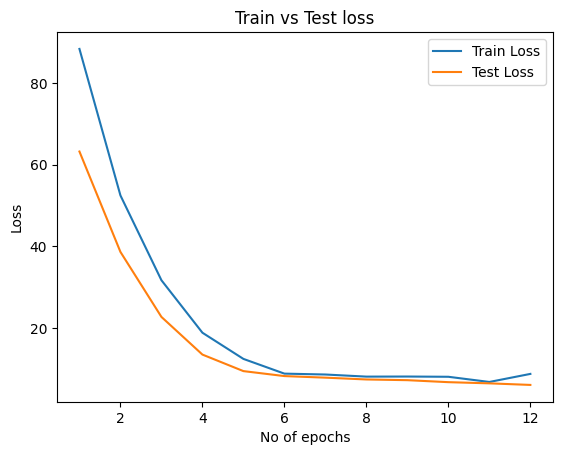

In [15]:
train_model(model, train_dataloader, test_dataloader, optimizer, num_epochs, accumulation_steps)

In [16]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

def get_text_embeddings(model, dataframe, device):
    model.eval()  # Set model to evaluation mode
    embeddings = {}

    # Define a batch size (adjust based on GPU memory)
    batch_size = 16

    with torch.no_grad():
        for i in range(0, len(dataframe), batch_size):
            # Get a batch of data
            batch_df = dataframe.iloc[i:i+batch_size]  # Efficient batch slicing

            # Collect city names and preprocessed text (if needed)
            city_names = list(batch_df['city'])
            texts = [preprocess_text(text) for text in batch_df['paragraphs']]

            # Convert text to tensors on GPU
            text_tensors = tokenizer(texts, padding="max_length", return_tensors="pt", truncation=True).to(device)

            # Forward pass through TextEncoder and projection network (batch processing)
            text_embeddings = model.text_encoder(text_tensors)
            text_projections = model.text_projection(text_embeddings)

            # Concatenate embeddings and projections, detach from GPU
            combined_embeddings = torch.cat([text_embeddings, text_projections], dim=1).detach()

            # Add embeddings to dictionary
            for city_name, embedding in zip(city_names, combined_embeddings):
                embeddings[city_name] = embedding.cpu()

    return embeddings


In [17]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

def get_text_embeddings_500(model, dataframe, device):
    model.eval()  # Set model to evaluation mode
    embeddings = {}

    # Define a batch size (adjust based on GPU memory)
    batch_size = 16

    with torch.no_grad():
        for i in range(0, len(dataframe), batch_size):
            # Get a batch of data
            batch_df = dataframe.iloc[i:i+batch_size]  # Efficient batch slicing

            # Collect city names and preprocessed text (if needed)
            city_names = list(batch_df['city'])
            texts = [preprocess_text(text) for text in batch_df['paragraphs']]

            # Convert text to tensors on GPU
            text_tensors = tokenizer(texts, padding="max_length", return_tensors="pt", truncation=True).to(device)

            # Forward pass through TextEncoder and projection network (batch processing)
            text_embeddings = model.text_encoder(text_tensors)
            text_projections = model.text_projection(text_embeddings).detach()

            # Concatenate embeddings and projections, detach from GPU
            #combined_embeddings = torch.cat([text_embeddings, text_projections], dim=1).detach()

            # Add embeddings to dictionary
            for city_name, embedding in zip(city_names, text_projections):
                embeddings[city_name] = embedding.cpu()

    return embeddings


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

data_path = "/kaggle/input/indian-data/indian_city_data.json"
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)
indian_df = pd.DataFrame(data)

indian_embeddings_dict = get_text_embeddings(model, indian_df, device)
with open("indian_city_embeddings_12ep_500.pickle", "wb") as f:
  pickle.dump(indian_embeddings_dict, f)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

data_path = "/kaggle/input/indian-data/indian_city_data.json"
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)
indian_df = pd.DataFrame(data)

indian_embeddings_dict = get_text_embeddings_500(model, indian_df, device)
with open("indian_city_embeddings_12ep_500only.pickle", "wb") as f:
  pickle.dump(indian_embeddings_dict, f)

In [20]:
data_path = "/kaggle/input/foreign-data/foreign_city_data copy.json"
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)
foreign_df = pd.DataFrame(data)

foreign_embeddings_dict = get_text_embeddings(model, foreign_df, device)
with open("foreign_city_embeddings_12ep_500.pickle", "wb") as f:
  pickle.dump(foreign_embeddings_dict, f)

In [21]:
data_path = "/kaggle/input/foreign-data/foreign_city_data copy.json"
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)
foreign_df = pd.DataFrame(data)

foreign_embeddings_dict = get_text_embeddings_500(model, foreign_df, device)
with open("foreign_city_embeddings_12ep_500only.pickle", "wb") as f:
  pickle.dump(foreign_embeddings_dict, f)